In [9]:
import mido
import numpy as np
import os
import sys
from mido import Message, MidiFile, MidiTrack
from operator import itemgetter
import midi
import random
import wavio
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [320]:
def plotWave (y, pltLen):
    if (len(y)<pltLen):
        print("Padding with zeros")
        diff = pltLen-len(y)
        z = np.zeros((diff,1))
        #print(y.shape,z.shape)
        y = np.concatenate((y,z), axis=0)
    
    x = np.arange(pltLen)
    plt.plot(x,y[0:pltLen])
    plt.show()
    
def seconds2samples (seconds, samplerate):
    return int(np.ceil(samplerate*seconds))

In [132]:
midi_example_dir = "Midi Files/Full Midi/"

#midi_filename = 'Hard Rock/8th Grooves/135 Basic 1 Ride F5.mid'
#midi_filename = 'Retro Funk/Grooves/096 Lowdown A.mid'
#midi_filename = 'Hard Rock/8th Grooves/150 Clave 1 OH F3.mid'
midi_filename = 'Reaper3.mid'

midi_dir = midi_example_dir + midi_filename

midi_list = [midi_filename]

dictionary = {}
dictionary["/Kick"] = 1
dictionary["/Snares"] = 2
dictionary["/Toms"] = 4
dictionary["/Cymbals/Hi Hats"] = 8

In [133]:
mid = mido.MidiFile(midi_dir)
pattern = midi.read_midifile(midi_dir)

ticks_per_beat = pattern.resolution
bpm = 120
midi_tempo = mido.bpm2tempo(bpm)
samplerate = 44100
elapsed_time = 0
midi_list = []
note_dict = {}

print("Midi File Length " + str(mid.length))

for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        print(msg)
        if ((not msg.is_meta) and msg.type[:4] == 'note'):
            elapsed_time += msg.time
            #convert ticks to samples
            in_sec = mido.tick2second(elapsed_time, ticks_per_beat, midi_tempo)
            time_in_samples = seconds2samples(in_sec, samplerate)
            #print(time_in_samples)
            midi_list.append([msg.note, msg.type, time_in_samples, msg.velocity])
        

            if msg.note in note_dict:
                if (msg.type == 'note_on'):
                    note_dict[msg.note].append([time_in_samples, 0, msg.velocity])
                elif (msg.type == 'note_off'):
                    note_dict[msg.note][-1][1] = time_in_samples
            else:
                note_dict[msg.note] = [[time_in_samples, 0, msg.velocity]]
                
print(note_dict)

Midi File Length 9.5015625
Track 0: 
note_on channel=0 note=44 velocity=96 time=0
note_off channel=0 note=44 velocity=0 time=480
note_on channel=0 note=36 velocity=96 time=240
note_off channel=0 note=36 velocity=0 time=480
note_on channel=0 note=37 velocity=96 time=240
note_off channel=0 note=37 velocity=0 time=480
note_on channel=0 note=36 velocity=96 time=240
note_off channel=0 note=36 velocity=0 time=480
note_on channel=0 note=43 velocity=96 time=0
note_off channel=0 note=43 velocity=0 time=480
note_on channel=0 note=43 velocity=96 time=240
note_on channel=0 note=38 velocity=96 time=240
note_off channel=0 note=43 velocity=0 time=240
note_off channel=0 note=38 velocity=0 time=240
note_on channel=0 note=36 velocity=96 time=240
note_on channel=0 note=44 velocity=104 time=0
note_off channel=0 note=44 velocity=0 time=454
note_off channel=0 note=36 velocity=0 time=26
note_on channel=0 note=36 velocity=96 time=0
note_on channel=0 note=37 velocity=96 time=0
note_off channel=0 note=36 veloci

<midi file 'Midi Files/Full Midi/Reaper3.mid' type 0, 1 tracks, 40 messages>

In [135]:
def sort_by_freq (note_dict):
    most_freq_notes = []

    #sort by frequency
    sorted_by_freq = [(k, note_dict[k]) for k in sorted(note_dict, key=lambda k: len(note_dict[k]), reverse=True)]
    s = filter_num - len(sorted_by_freq)
    if (s<=0):
        most_freq_notes = sorted_by_freq[:filter_num]
    else:
        print("not enough midi notes")
        #fill in for any missing notes
    
    return most_freq_notes


def sort_by_note(note_events):
    #sort by note
    sorted_by_note = sorted(note_events, key=itemgetter(0))
    return sorted_by_note
    

filter_num = len(dictionary)
most_freq_notes = sort_by_freq (note_dict)
print([(i[0], len(i[1])) for i in most_freq_notes])
sorted_by_note = sort_by_note(most_freq_notes)
print([(i[0], len(i[1])) for i in sorted_by_note])

inst = ['Kick', 'Snare', 'Tom', 'Cymbal']
print(inst)
print([x for (y,x) in sorted(zip(sorted_by_note, inst), key=lambda pair: pair[0], reverse=False)])
#most_freq_notes = sorted(note_dict, key=itemgetter(1), reverse=True)

print(sorted_by_note)

[(36, 6), (43, 5), (37, 4), (44, 3)]
[(36, 6), (37, 4), (43, 5), (44, 3)]
['Kick', 'Snare', 'Tom', 'Cymbal']
['Kick', 'Snare', 'Tom', 'Cymbal']
[(36, [[16538, 27563, 96], [49613, 60638, 96], [99225, 110250, 96], [110250, 121275, 96], [143325, 154350, 116], [159863, 170888, 96]]), (37, [[33075, 44100, 96], [110250, 121275, 96], [126788, 137813, 96], [159863, 170888, 96]]), (43, [[60638, 71663, 96], [77175, 88200, 96], [126788, 137813, 96], [143325, 154350, 116], [159863, 170888, 96]]), (44, [[0, 11025, 96], [99225, 109653, 104], [159863, 170888, 96]])]


In [361]:
def moving_average(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def curtail(audio):
    if (len(audio.shape)==1):
        audio=audio.reshape((len(audio),1))
    length = len(audio)
    threshold = .0005
    power = np.power(audio,2)
    power = moving_average(power, n=7000)
    
    max_p = np.max(power)
    min_p = np.min(power)
    power = (power-min_p)/(max_p-min_p)
    
    plotWave(audio,length)
    plotWave(power,len(power))
    
    max_power = 0
    for t in range(len(power)):
        curr_val = power[t]
        if(max_power<curr_val):
            max_power=curr_val
        elif(threshold*max_power>curr_val):
            audio = audio[:t,:]
            break
    
    plotWave(audio,length)
    return audio

In [403]:
#pick out <samples_per_class> number of wav files per instrument class
sample_folder = "/Analog Drums"
exclude = set(["test set", "Vocals & Chants", "Silence", "Drum Loops", "pyAudioAnalysis"])
samples_per_class = 1
wav_dict = {}

for folder in dictionary:
    print(sample_folder + folder)
    for root, dirs, files in os.walk("." + sample_folder + folder, topdown=True):
        wav_files = [ fi for fi in files if (fi.endswith(".wav") or fi.endswith(".WAV")) ]
        wav_list = random.sample(wav_files, samples_per_class)
        wav_list = [os.path.join(root, name) for name in wav_list]
        wav_dict[folder] = wav_list
        print(wav_list)

/Analog Drums/Kick
['./Analog Drums/Kick/JUST_kick_cyrax.wav']
/Analog Drums/Cymbals/Hi Hats
['./Analog Drums/Cymbals/Hi Hats/ZDJN_HAT_C2FL_HT_015_03.wav']
/Analog Drums/Snares
['./Analog Drums/Snares/L400_SNR_LEFL_HT_01.wav']
/Analog Drums/Toms
['./Analog Drums/Toms/LWFI_SNR_OFFL_HT_02.wav']


[('/Kick', 1), ('/Snares', 2), ('/Toms', 4), ('/Cymbals/Hi Hats', 8)]
('/Kick', './Analog Drums/Kick/JUST_kick_cyrax.wav')


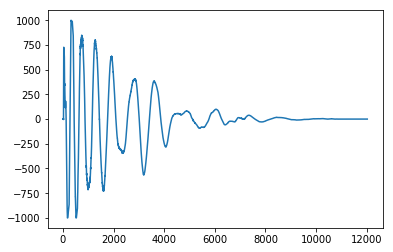

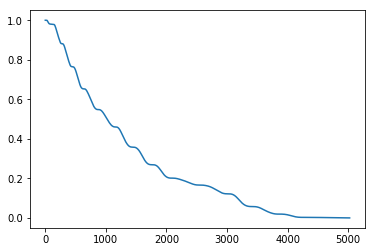

Padding with zeros


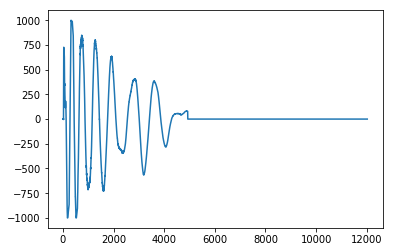

(4929, 1)
(44100, 2)
('/Snares', './Analog Drums/Snares/L400_SNR_LEFL_HT_01.wav')


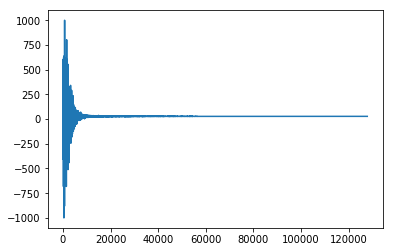

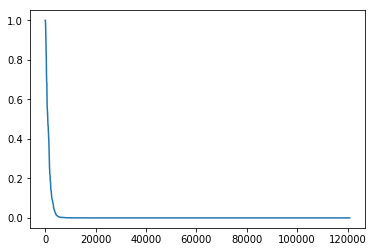

Padding with zeros


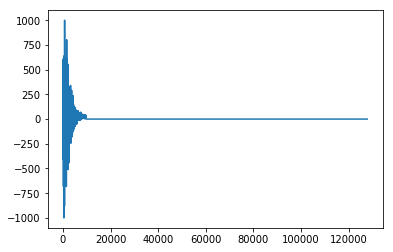

(9616, 1)
(44100, 3)
('/Toms', './Analog Drums/Toms/LWFI_SNR_OFFL_HT_02.wav')


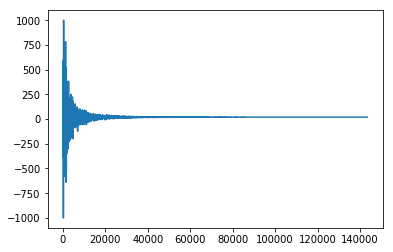

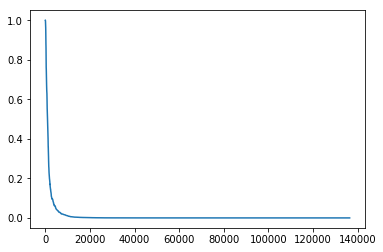

Padding with zeros


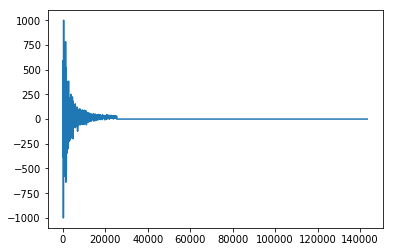

(25290, 1)
(44100, 3)
('/Cymbals/Hi Hats', './Analog Drums/Cymbals/Hi Hats/ZDJN_HAT_C2FL_HT_015_03.wav')


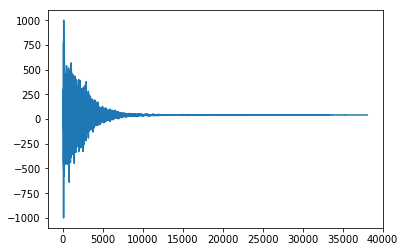

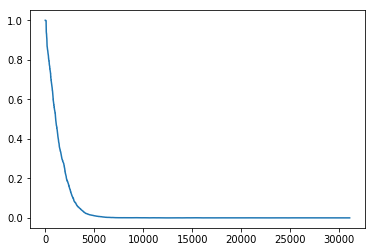

Padding with zeros


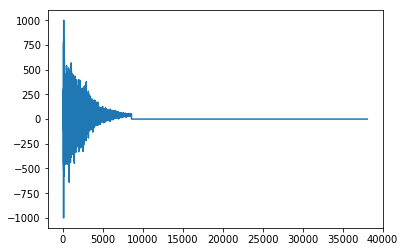

(8573, 1)
(44100, 3)


In [412]:
wav_output_dir = "Output_Audio/"

length_in_samples = seconds2samples(mid.length/2, samplerate)
#time_series = np.zeros((length_in_samples,2), dtype="float32")
time_series = np.random.normal(size = (length_in_samples,2))
time_label = np.zeros(length_in_samples, dtype = "uint8")
selected_samples = []

labels = dictionary.items()
labels = sorted(labels, key=itemgetter(1))
print(labels)

for i in range(len(labels)):
    label = labels[i][0]
    label_num = labels[i][1]
    wav_list = wav_dict[label]
    selected = random.choice(wav_list)
    print(label, selected)
    selected_samples.append(selected.split('/')[-1].split(".")[0])
    
    wavio_obj = wavio.read(selected)
    wav = wavio_obj.data
    rate = wavio_obj.rate
    sampwidth = wavio_obj.sampwidth
    
    if(wav.shape[1]==2):
        wav = (wav[:,0]+wav[:,1])/2
    
    scaler = preprocessing.MinMaxScaler(feature_range = (-1000,1000))
    wav = scaler.fit_transform(wav)
    wav = curtail(wav)
    wav_length = len(wav)
    print(wav.shape)
    
    print(rate, sampwidth)
    
    note_list = sorted_by_note[i][1]
    for n in note_list:
        note_len = n[1]-n[0]
        if((wav_length > note_len)):
            #print("wav is bigger", n)
            #print(n[0],n[1])
            #print(note_len)
            time_series[n[0]:n[1]] += wav[:note_len]*(n[2]/127.)
            time_label[n[0]:n[1]] = np.bitwise_or(time_label[n[0]:n[1]], np.ones(note_len, dtype = time_label.dtype)*label_num)
        else:
            #print("MIDI is bigger")
            
            #if it sample extends past end of audio file
            if(wav_length> length_in_samples-n[0]):
                appender = np.zeros((length_in_samples-n[0],2), dtype = time_series.dtype)
                appender_label = np.zeros(length_in_samples-n[0], dtype = time_label.dtype)
                time_series = np.concatenate((time_series, appender))
                time_label = np.concatenate((time_label, appender_label))
                
            time_series[n[0]:n[0]+wav_length] += wav[:]*(n[2]/127.)
            time_label[n[0]:n[0]+wav_length] = np.bitwise_or(time_label[n[0]:n[0]+wav_length], np.ones(wav_length, dtype = time_label.dtype)*label_num)

### Apply Reverb ###


(209510,)
(209510, 8)


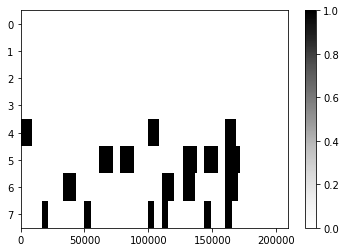

In [413]:
print(time_label.shape)
time_label_binary = np.unpackbits(time_label.reshape((len(time_label),1)), axis=1)
print(time_label_binary.shape) 
plt.imshow(np.transpose(time_label_binary), cmap='Greys', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

In [406]:

name = midi_filename.split("/")[-1].split(".")[0]
sample_names = ''
for s in range(len(selected_samples)):
    print(selected_samples[s]) 
    sample_names = sample_names + ", " + selected_samples[s]
wav_filename = wav_output_dir + name + sample_names + ".wav"
label_filename = wav_output_dir + "label_" + name + sample_names + ".wav"

#scale final audio vector
scaler = preprocessing.MinMaxScaler(feature_range = (-100,100))
time_series = scaler.fit_transform(time_series)

wavio.write(wav_filename , time_series, samplerate, sampwidth=3)
np.save(label_filename, time_label_binary)
print("wrote wav file named: " + wav_filename)

JUST_kick_cyrax
L400_SNR_LEFL_HT_01
LWFI_SNR_OFFL_HT_02
ZDJN_HAT_C2FL_HT_015_03
wrote wav file named: Output_Audio/Reaper3, JUST_kick_cyrax, L400_SNR_LEFL_HT_01, LWFI_SNR_OFFL_HT_02, ZDJN_HAT_C2FL_HT_015_03.wav


In [461]:
"""
0000 : E -> 0

0001 : K -> 1
0010 : S -> 2
0100 : T -> 4
1000 : C -> 8

get union of several events by ORing the corresponding binary
ex: K+C -> 0001 OR 1000 = 1001

plan: 

- create several midi segments (make like 20)

- randomly stitch together several midi segments and save to midi file (maybe 2 or 4 segments per file)

- get a list of every note number, containing a list of tuples where (i,j) = (start, end) of every note

- Create large array of length of midi file, one for audio, another for the labels over time

- randomly pick a wav file from each category

- iterating over instrument, insert the raw wave into the corresponding start pos for each note, and update label vector by ORing with the label of the wav being added:
	- midi lasts longer than wav -> insert wav normally, label to wav length
	- midi lasts shorter than wav - > insert wav curtailed by midi length, label to midi length

- convert label vector entries to binary

- save audio vector to wav file, then save the audio vector with label vector to np/h5 file
"""

'\n0000 : E -> 0\n\n0001 : K -> 1\n0010 : S -> 2\n0100 : T -> 4\n1000 : C -> 8\n\nget union of several events by ORing the corresponding binary\nex: K+C -> 0001 OR 1000 = 1001\n\nplan: \n\n- create several midi segments (make like 20)\n\n- randomly stitch together several midi segments and save to midi file (maybe 2 or 4 segments per file)\n\n- get a list of every note number, containing a list of tuples where (i,j) = (start, end) of every note\n\n- Create large array of length of midi file, one for audio, another for the labels over time\n\n- randomly pick a wav file from each category\n\n- iterating over instrument, insert the raw wave into the corresponding start pos for each note, and update label vector by ORing with the label of the wav being added:\n\t- midi lasts longer than wav -> insert wav normally, label to wav length\n\t- midi lasts shorter than wav - > insert wav curtailed by midi length, label to midi length\n\n- convert label vector entries to binary\n\n- save audio vec

In [621]:
d = np.array([[1,2,3],[4,5,6]])
print(d.shape)
d = np.expand_dims(d,axis=0)
print(d.shape)
g = np.vstack((d,d))
print(g.shape)
print(g)

(2, 3)
(1, 2, 3)
(2, 2, 3)
[[[1 2 3]
  [4 5 6]]

 [[1 2 3]
  [4 5 6]]]
